In [1]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

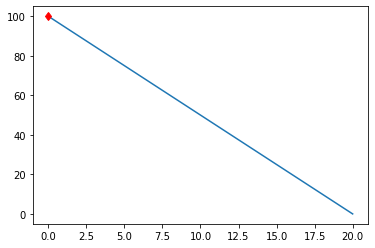

In [3]:

for condition in fm.conditions:
    condition.set_condition_profile()
    condition.plot_condition_profile()

In [7]:
timeline = fm.sim_timeline(50)

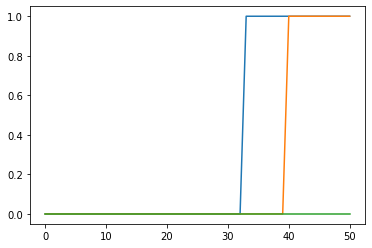

In [8]:
plt.plot(timeline['initiated'])
plt.plot(timeline['detection'])
plt.plot(timeline['failure'])